### Mechanical Power Vital File EDA
* Sangwon Baek / SNUH / Vital Lab 
* Jan 9th 2024 

In [1]:
import vitaldb

import pandas as pd
from pandas import Timestamp, Timedelta
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from itertools import chain
from tqdm import tqdm
import datetime

import re
import os
import glob
import random
from collections import defaultdict
import gc  # Garbage Collector

from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Display first 50 rows of dataframe
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

import matplotlib as mpl 

#Set Global Matplotlib parameters for font 
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12

In [2]:
def collect_file_npz(years):
    # Initialize a dictionary to hold filenames and file paths for each year
    file_names, file_paths = {}, {}

    # Initialize an empty list to store all file paths across years
    all_filenames, all_file_paths = [], []

    # Iterate over each year, get filenames, and count .vital files
    for year in years:
        path = f'../Data/VitalNPZ/{year}/'
        try:
            filenames = os.listdir(path)
        except FileNotFoundError:
            print(f"Directory not found: {path}")
            continue

        # Store filenames and file paths for the current year
        file_names[year] = filenames
        year_file_paths = [os.path.join(path, filename) for filename in filenames]
        file_paths[year] = year_file_paths

        # Extend all_file_paths list with file paths from the current year
        all_file_paths.extend(year_file_paths)
        all_filenames.extend(filenames)

        # Count and print the number of .npz files
        npz_file_count = len([f for f in filenames if f.endswith('.npz')])
        print(f'Got a total of {npz_file_count} vital files for MP research in 20{year}')

    return file_names, file_paths, all_filenames, all_file_paths

def stratified_sampling_npz(directory_paths, sample_size=1):
    def extract_op_room(filename):
        return filename.split('_')[0]

    file_names = {}
    for year, path in directory_paths.items():
        filenames = os.listdir(path)
        file_names[year] = [os.path.join(f'../Data/VitalNPZ/{year}/', fname) for fname in filenames]  # Prepend the path to filenames

    # Group filenames by year and operation room
    stratified_groups = defaultdict(lambda: defaultdict(list))
    for year, filenames in file_names.items():
        for fname in filenames:
            op_room = extract_op_room(fname)
            stratified_groups[year][op_room].append(fname)

    # Perform stratified random sampling
    sampled_filenames = []
    for year, op_rooms in stratified_groups.items():
        for op_room, fnames in op_rooms.items():
            if len(fnames) >= sample_size:
                sampled_filenames.extend(random.sample(fnames, sample_size))
            else:
                sampled_filenames.extend(fnames)
    
    # Print the number of files sampled
    print(f"Sampled {len(sampled_filenames)} files")
    return sampled_filenames

def extract_year_from_path(file_path):
    year_match = re.search(r'/(\d{2})/', file_path)
    return "20" + str(year_match.group(1)) if year_match else "Unknown"

def reformat_filenames_vital(original_filename):
    # Remove the '.vital' extension from the original filename
    base_filename = original_filename[:-6]  # Assuming '.vital' is always the extension and is 6 characters long
    
    # Split the base filename to extract the necessary parts
    parts = base_filename.split('_')
    if len(parts) > 1:
        # Extract the year part (first two digits after the underscore)
        year_part = parts[1][:2]
        # Construct the new filename, appending '_MP.npz' at the end
        new_filename = f"../Data/VitalNPZ/{year_part}/{base_filename}_MP.npz"
        return new_filename
    else:
        # If the filename doesn't match the expected pattern, append '_MP.vital' to the original base filename
        return f"{base_filename}_MP.npz"
    
def get_filtered_reformatted_filenames(df, threshold):
    # Filter DataFrame based on MP Missing Rate threshold
    filtered_df = df[df['MP Missing Rate'] <= threshold]
    
    # Apply reformatting to each filename in the filtered DataFrame
    reformatted_filenames = filtered_df['File Name'].apply(reformat_filenames_vital).tolist()
    
    return reformatted_filenames

In [3]:
def load_single_npz_file(file_path):
    try:
        with np.load(file_path, allow_pickle=True) as data:
            vital_array = data['vital_data']
            track_names = data['track_names']

        track_names = np.insert(track_names, 0, "Time")
        return pd.DataFrame(vital_array, columns=track_names)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    
def get_column_data(df, search_string):
    for column in df.columns:
        if search_string in column:
            return df[column].dropna().tolist()
    return []

def process_single_npz_file(file_path):
    # Extract the year and filename
    year = extract_year_from_path(file_path)
    filename = os.path.basename(file_path)
    df = load_single_npz_file(file_path)
    
    # Initialize variables to track negative MP values
    negative_mp = False
    negative_timestamps = []  # For tracking timestamps of negative MP values
    combined_mp = []
    mv, tv, rr = [], [], []
    peep, peak_pressure, plateau_pressure, f = [], [], [], []
    co2, compliance = [], []
    hr, sbp, spo2 = [], [], []

    if df is not None:
        timestamps = df['Time'].tolist()

        # Extracting mechanical power columns
        combined_mp_data = df['Mechanical Power 60/MP_COMBINED_60'].dropna()
        combined_mp = combined_mp_data.tolist()

        # Extracting additional columns using the helper function
        mv = get_column_data(df, 'Mechanical Power 60/MV')
        tv = get_column_data(df, 'Mechanical Power 60/TV')
        rr = get_column_data(df, 'Mechanical Power 60/RR')
        peep = get_column_data(df, 'Mechanical Power 60/PEEP')
        peak_pressure = get_column_data(df, 'Mechanical Power 60/Peak Pressure')
        plateau_pressure = get_column_data(df, 'Mechanical Power 60/Plateau Pressure')
        f = get_column_data(df, 'Mechanical Power 60/F')
        co2 = get_column_data(df, 'Mechanical Power 60/CO2')
        compliance = get_column_data(df, 'Mechanical Power 60/Compliance')
        hr = get_column_data(df, 'Mechanical Power 60/HR')
        sbp = get_column_data(df, 'Mechanical Power 60/SBP')
        spo2 = get_column_data(df, 'Mechanical Power 60/SPO2')

        # Check for negative values in MP data
        for idx, val in combined_mp_data.items():
            if val < 0:
                negative_mp = True
                negative_timestamps.append(timestamps[idx])  # Track timestamp of negative value


    return year, negative_mp, negative_timestamps, filename, combined_mp, mv, tv, rr, peep, peak_pressure, plateau_pressure, f, co2, compliance, hr, sbp, spo2


def process_all_npz_files(file_paths):
    results = Parallel(n_jobs=os.cpu_count())(delayed(process_single_npz_file)(fp) for fp in tqdm(file_paths, desc="Processing Files"))

    # Initialize dictionaries to store data per year
    combined_mp_data = {}
    mv_data, tv_data, rr_data = {}, {}, {}
    peep_data, peak_pressure_data, plateau_pressure_data, f_data = {}, {}, {}, {}
    co2_data, compliance_data = {}, {}
    hr_data, sbp_data, spo2_data = {}, {}, {}
    negative_mp_files = []

    for year, negative_mp, negative_timestamps, filename, combined_mp, mv, tv, rr, peep, peak_pressure, plateau_pressure, f, co2, compliance, hr, sbp, spo2 in results:
        # Initialize the year if not present
        for data_dict in (combined_mp_data, mv_data, tv_data, rr_data, peep_data, peak_pressure_data, plateau_pressure_data, f_data, co2_data, compliance_data, hr_data, sbp_data, spo2_data):
            if year not in data_dict:
                data_dict[year] = []

        # Extend data for each year
        combined_mp_data[year].extend(combined_mp)
        mv_data[year].extend(mv)
        tv_data[year].extend(tv)
        rr_data[year].extend(rr)
        peep_data[year].extend(peep)
        peak_pressure_data[year].extend(peak_pressure)
        plateau_pressure_data[year].extend(plateau_pressure)
        f_data[year].extend(f)
        co2_data[year].extend(co2)
        compliance_data[year].extend(compliance)
        hr_data[year].extend(hr)
        sbp_data[year].extend(sbp)
        spo2_data[year].extend(spo2)

        if negative_mp:
            negative_mp_files.append((filename, negative_timestamps))

    return negative_mp_files, combined_mp_data, mv_data, tv_data, rr_data, peep_data, peak_pressure_data, plateau_pressure_data, f_data, co2_data, compliance_data, hr_data, sbp_data, spo2_data

In [4]:
def calculate_descriptive_stats_dataframe(data_dict):
    if not data_dict:  # Check if the data_dict is empty
        print("Data dictionary is empty. Returning an empty DataFrame.")
        return pd.DataFrame()

    stats_list = []
    all_data = []  # List to hold all data across years for final aggregation

    for year, data in data_dict.items():
        if not data:  # Skip empty datasets
            print(f"Warning: No data for {year}, skipping.")
            continue  # Skip this iteration and continue with the next

        all_data.extend(data)  # Add data to the all_data list
        stats = {
            'Year': year,
            'count': f"{len(data):,}",
            'mean': round(np.mean(data), 2) if data else None,
            'std': round(np.std(data), 2) if data else None,
            'min': round(np.min(data), 2) if data else None,
            '25%': round(np.percentile(data, 25), 2) if data else None,
            '50%': round(np.median(data), 2) if data else None,
            '75%': round(np.percentile(data, 75), 2) if data else None,
            'max': round(np.max(data), 2) if data else None
        }
        stats_list.append(stats)

    if not all_data:  # Check if all_data is empty before calculating combined stats
        print("All data across years is empty. No combined statistics calculated.")
    else:
        # Calculate stats for combined data
        combined_stats = {
            'Year': 'Combined',
            'count': f"{len(all_data):,}",
            'mean': round(np.mean(all_data), 2),
            'std': round(np.std(all_data), 2),
            'min': round(np.min(all_data), 2),
            '25%': round(np.percentile(all_data, 25), 2),
            '50%': round(np.median(all_data), 2),
            '75%': round(np.percentile(all_data, 75), 2),
            'max': round(np.max(all_data), 2)
        }
        stats_list.append(combined_stats)

    stats_df = pd.DataFrame(stats_list)
    return stats_df

def calculate_and_store_stats(data_dicts):
    stats_dfs = {}
    for data_key, data in data_dicts.items():
        stats_df = calculate_descriptive_stats_dataframe(data)
        stats_dfs[data_key] = stats_df
    return stats_dfs

def create_pivot_table(descriptive_stats_dfs):
    # Concatenate all DataFrames into one
    all_stats = []
    for key, df in descriptive_stats_dfs.items():
        df['Component'] = key  # Add a new column for the component name
        all_stats.append(df)

    combined_df = pd.concat(all_stats)

    # Pivot the DataFrame without swapping levels or sorting
    pivot_df = combined_df.pivot_table(index='Year', 
                                       columns='Component', 
                                       values=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'],
                                       aggfunc='first').swaplevel(0, 1, axis=1).sort_index(axis=1)
    
    # Reorder the columns manually
    desired_order = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    pivot_df = pivot_df.reindex(desired_order, axis=1, level=1)
    
    return pivot_df

def plot_histograms(mp_data, mp_name, bins=100):
    plt.figure(figsize=(20, 10))  # Adjust the figure size if needed

    # Plot histograms for each year from 2017 to 2020
    for i, (year, data) in enumerate(mp_data.items()):
        if i < 4:  # First 4 years (17, 18, 19, 20) in the first row
            plt.subplot(2, 4, i + 1)
            plt.hist(data, bins=bins, color='blue', edgecolor='black')
            plt.title(f'{mp_name} for {year}')
            plt.xlabel(f'Total Count: {len(data)}')
            plt.ylabel('Frequency')

    # Plot histograms for each year from 2021 to 2023
    for i, (year, data) in enumerate(list(mp_data.items())[4:7], start=1):
        plt.subplot(2, 4, i + 4)  # Plotting in the second row
        plt.hist(data, bins=bins, color='blue', edgecolor='black')
        plt.title(f'{mp_name} for {year}')
        plt.xlabel(f'Total Count: {len(data)}')

    # Plot histogram for combined data in the last position of the second row
    combined_data = [value for year_data in mp_data.values() for value in year_data]
    plt.subplot(2, 4, 8)
    plt.hist(combined_data, bins=bins, color='green', edgecolor='black')
    plt.title(f'Combined {mp_name} for All Years')
    plt.tight_layout()
    plt.xlabel(f'Total Count: {len(combined_data)}')
    plt.savefig(f'../Results/{mp_name}_histogram.png', dpi=600, bbox_inches='tight')
    plt.show()

def plot_combined_mp_histogram(mp_data, mp_name, bins=100):
    # Combine data from all years
    combined_data = [value for year_data in mp_data.values() for value in year_data]

    # Plotting the histogram for combined data
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.hist(combined_data, bins=bins, color='purple', edgecolor='black')
    plt.title(f'Combined {mp_name} for All Years')
    plt.xlabel(f'Total Count: {len(combined_data)}')
    plt.ylabel('Frequency')
    plt.show()

def calculate_below_threshold(data_dict, threshold, label):
    counts = sum(1 for _, data in data_dict.items() for val in data if val <= threshold)
    total_values = sum(len(data) for data in data_dict.values())
    percentage = counts / total_values * 100

    print(f"Total number of {label} values <= {threshold}: {counts}")
    print(f"Percentage of total {label} values: {percentage:.2f}%")

In [5]:
years = range(17, 24)
# Get sampled file paths through stratified sampling
directory_paths = {year: f'../Data/VitalNPZ/{year}/' for year in range(17, 24)}
sampled_file_paths = stratified_sampling_npz(directory_paths)
file_names, file_paths, all_filenames, all_file_paths = collect_file_npz(years)
print(f"Total number of files: {len(all_file_paths)}")

# Read missing rate files.csv and save afe mr_files_df 
mr_files_df = pd.read_csv('../Results/Missing_Rate_Files.csv')
necessary_file_paths = get_filtered_reformatted_filenames(mr_files_df, 0.2)
print(f"File paths after filtering: {len(necessary_file_paths)}")


Sampled 249 files
Got a total of 4384 vital files for MP research in 2017
Got a total of 5465 vital files for MP research in 2018
Got a total of 6724 vital files for MP research in 2019
Got a total of 7545 vital files for MP research in 2020
Got a total of 8938 vital files for MP research in 2021
Got a total of 9776 vital files for MP research in 2022
Got a total of 3993 vital files for MP research in 2023
Total number of files: 46825
File paths after filtering: 45465


In [6]:
# Process all files and store the results
negative_mp_files, combined_mp_data, mv_data, tv_data, rr_data, peep_data, peak_pressure_data, plateau_pressure_data, f_data, co2_data, compliance_data, hr_data, sbp_data, spo2_data = process_all_npz_files(necessary_file_paths)

Processing Files: 100%|██████████| 45465/45465 [54:00<00:00, 14.03it/s]  


In [7]:
negative_mp_files

[('D1_200508_143735_MP.npz',
  [Timestamp('2020-05-08 16:42:11.913081+0900', tz='UTC+09:00'),
   Timestamp('2020-05-08 16:42:17.913081+0900', tz='UTC+09:00'),
   Timestamp('2020-05-08 16:42:23.913081+0900', tz='UTC+09:00'),
   Timestamp('2020-05-08 16:42:29.913081+0900', tz='UTC+09:00'),
   Timestamp('2020-05-08 16:42:35.913081+0900', tz='UTC+09:00'),
   Timestamp('2020-05-08 16:42:41.913081+0900', tz='UTC+09:00'),
   Timestamp('2020-05-08 16:42:47.913081+0900', tz='UTC+09:00'),
   Timestamp('2020-05-08 16:42:53.913081+0900', tz='UTC+09:00'),
   Timestamp('2020-05-08 16:42:59.913081+0900', tz='UTC+09:00'),
   Timestamp('2020-05-08 16:43:05.913081+0900', tz='UTC+09:00'),
   Timestamp('2020-05-08 16:43:11.913081+0900', tz='UTC+09:00')]),
 ('E1_180328_073914_MP.npz',
  [Timestamp('2018-03-28 11:07:31.886500+0900', tz='UTC+09:00')]),
 ('D5_170928_074927_MP.npz',
  [Timestamp('2017-09-28 08:16:32.753000+0900', tz='UTC+09:00')]),
 ('B2_201116_135146_MP.npz',
  [Timestamp('2020-11-16 15:17:22

In [8]:
# Calculate counts below certain threshold
calculate_below_threshold(peak_pressure_data, 10, "peak pressure")
calculate_below_threshold(plateau_pressure_data, 10, "plateau pressure")
calculate_below_threshold(f_data, 0, "F")
calculate_below_threshold(combined_mp_data, 0, "combined mp")

data_to_process = {
    "Combined_MP": combined_mp_data,
    "MV": mv_data,
    "TV": tv_data,
    "RR": rr_data,
    "PEEP": peep_data,
    "Peak Pressure": peak_pressure_data,
    "Plateau Pressure": plateau_pressure_data,
    "F": f_data,
    "CO2": co2_data,
    "Compliance": compliance_data,
    "HR": hr_data,
    "SBP": sbp_data,
    "SpO2": spo2_data
}
descriptive_stats_dfs = calculate_and_store_stats(data_to_process)
pivot_stats_df = create_pivot_table(descriptive_stats_dfs)
# Create this pivot table into a csv file 
pivot_stats_df.to_csv('../Results/MP_Pivot_Table.csv')
pivot_stats_df

# # Find distribution of combined_mp as a whole
# combined_mp_list = [value for sublist in combined_mp.values() for value in sublist]
# combined_mp_series = pd.Series(combined_mp_list)
# combined_mp_series.sort_values(ascending=False)

Total number of peak pressure values <= 10: 82452
Percentage of total peak pressure values: 0.12%
Total number of plateau pressure values <= 10: 57050
Percentage of total plateau pressure values: 0.09%
Total number of F values <= 0: 0
Percentage of total F values: 0.00%
Total number of combined mp values <= 0: 15
Percentage of total combined mp values: 0.00%


Component         CO2                                          Combined_MP  \
                count  mean  std  min   25%   50%   75%    max       count   
Year                                                                         
2017        7,066,326 34.56 3.23 0.00 33.00 34.00 36.00  69.00   6,932,816   
2018        9,040,205 34.58 3.37 0.00 33.00 34.00 36.00  86.00   8,921,181   
2019       10,221,642 34.50 3.15 0.00 33.00 34.00 36.00  75.00  10,089,491   
2020       11,792,135 35.13 3.41 0.00 33.00 35.00 37.00  72.68  11,653,541   
2021       13,121,595 35.19 3.07 0.00 33.66 35.00 37.00  99.00  12,684,865   
2022       13,221,946 35.33 3.07 0.00 33.66 35.19 37.00  89.50  12,790,084   
2023        5,257,064 35.15 3.13 0.00 33.66 35.00 37.00 412.34   5,083,167   
Combined   69,720,913 34.96 3.22 0.00 33.00 35.00 36.72 412.34  68,155,145   

Component       ...   SpO2                 TV                                \
          mean  ...    75%    max       count mean  std  min  25%  50%  75%   
Year            ...                                                           
2017      6.18  ... 100.00 100.00   7,059,864 0.41 0.08 0.01 0.35 0.40 0.46   
2018      7.62  ... 100.00 100.00   9,030,878 0.43 0.07 0.00 0.38 0.43 0.48   
2019      7.56  ... 100.00 100.00  10,214,270 0.44 0.07 0.00 0.39 0.43 0.48   
2020      8.33  ... 100.00 100.00  11,775,718 0.44 0.07 0.00 0.39 0.44 0.48   
2021      7.74  ... 100.00 100.00  12,945,220 0.44 0.07 0.00 0.40 0.44 0.49   
2022      7.19  ... 100.00 100.00  13,004,469 0.44 0.06 0.00 0.40 0.43 0.48   
2023      7.12  ... 100.00 100.00   5,166,545 0.44 0.06 0.00 0.40 0.43 0.48   
Combined  7.49  ... 100.00 100.00  69,196,964 0.43 0.07 0.00 0.39 0.43 0.48   

Component       
           max  
Year            
2017      2.02  
2018      2.60  
2019      3.95  
2020      1.99  
2021      3.68  
2022      7.10  
2023      2.92  
Combined  7.10  

[8 rows x 104 columns]

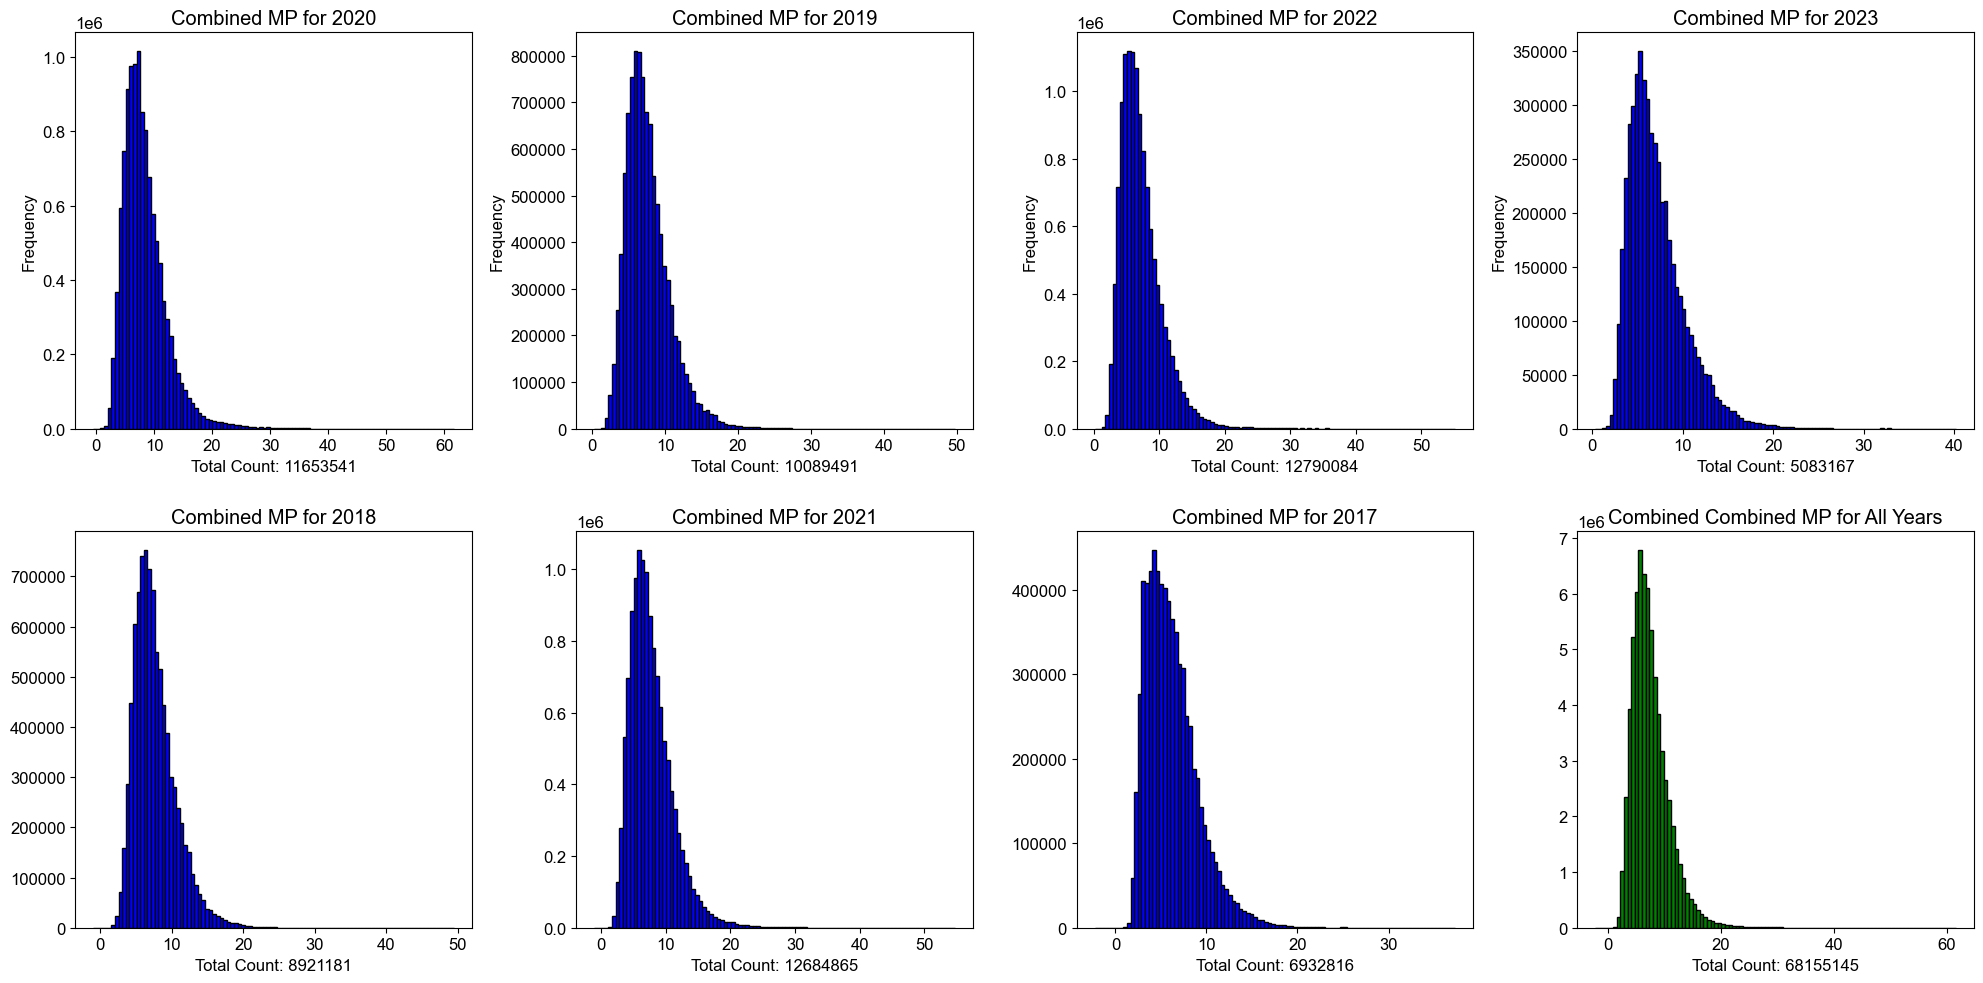

In [9]:
plot_histograms(combined_mp_data, 'Combined MP', bins=100)

In [10]:
def read_aggregate_dfs(length=None):
    # Read parquet files and create dataframe
    df_missing_rate = {}

    for i in range(0, length):
        df_missing_rate[i] = pd.read_parquet(f'../Data/MissingRate/missing_rate_batch_{i}.parquet')

    # Concatenate all dataframes into one dataframe
    df_missing_rate_combined = pd.concat([df_missing_rate[i] for i in range(0, length)])

    return df_missing_rate_combined

def aggregate_missing_rates(df, mp_missing_rate_threshold=0.00):
    # Apply filtering based on MP Missing Rate
    df['MP non-existing'] = df['MP Missing Rate'].apply(lambda x: True if x > mp_missing_rate_threshold else False)

    # Convert Boolean to Numeric (False to 0, True to 1)
    for col in ['MV', 'RR', 'TV', 'Peak Pressure', 'PEEP', 'Plateau Pressure', 'F', 'MP non-existing']:
        df[col] = df[col].astype(int)

    # Group by Year and calculate total file counts and missing file counts for each category
    result = df.groupby('Year').agg(
        total_files=('Year', 'size'),
        missing_files_mv=('MV', 'sum'),
        missing_files_rr=('RR', 'sum'),
        missing_files_tv=('TV', 'sum'),
        missing_files_peak_pressure=('Peak Pressure', 'sum'),
        missing_files_peep=('PEEP', 'sum'),
        missing_files_plateau_pressure=('Plateau Pressure', 'sum'),
        missing_files_f=('F', 'sum'),
        missing_files_mp_non_existing=('MP non-existing', 'sum')
    )

    # Calculate missing rates for each category
    for col in ['mv', 'peak_pressure', 'peep', 'plateau_pressure', 'f', 'mp_non_existing']:
        result[f'missing_rate_{col}'] = (result[f'missing_files_{col}'] / result['total_files']) * 100

    return result

def plot_missing_rates_with_counts(df, missing_rate_threshold=None):
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 10))

    # Preparing data for plotting
    categories = ['mv', 'peak_pressure', 'peep', 'plateau_pressure', 'f', 'mp_non_existing']
    melted_df_rates = df.reset_index().melt(id_vars=['Year', 'total_files'], 
                                            value_vars=[f'missing_rate_{cat}' for cat in categories], 
                                            var_name='Category', 
                                            value_name='Missing Rates (%)')
    melted_df_counts = df.reset_index().melt(id_vars=['Year', 'total_files'], 
                                             value_vars=[f'missing_files_{cat}' for cat in categories], 
                                             var_name='Category', 
                                             value_name='Missing File Counts')

    # Create a barplot for missing rates
    ax = sns.barplot(x="Year", y="Missing Rates (%)", hue="Category", data=melted_df_rates)

    # Annotate total file counts below the x-axis
    for i, year in enumerate(df.index):
        ax.text(i, -5, f'Total: {df.loc[year, "total_files"]}', ha='center', color='black')

    # Annotate missing file counts on top of each bar
    for p, missing_count in zip(ax.patches, melted_df_counts['Missing File Counts']):
        ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 1, f'{int(missing_count)}', ha='center', va='bottom')

    # Set the title with missing_rate_threshold if provided
    title = 'Missing Rates by Category per Year with Counts'
    if missing_rate_threshold is not None:
        title += f' (Allowance Threshold: {missing_rate_threshold*100}%)'
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Missing Rates (%)')
    # plt.xticks(rotation=45)
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Save the figure before showing
    plt.savefig('../Results/missing_rates_plot.png', bbox_inches='tight')

    plt.tight_layout()
    plt.show()


def plot_mr_violin_plots(df):
    # Isolating MP Missing Rates and Year
    relevant_data = df[['Year', 'MP Missing Rate']]

    # Filter out zero rates
    non_zero_rates = relevant_data[relevant_data['MP Missing Rate'] > 0]

    # Plotting
    plt.figure(figsize=(15, 7))

    # Violin plot for non-zero rates
    sns.violinplot(x='Year', y='MP Missing Rate', data=non_zero_rates)

    # Get the unique years
    unique_years = sorted(df['Year'].unique())

    # Reporting number of non-zero rates below the x-axis
    ax = plt.gca()  # Get current axis
    for i, year in enumerate(unique_years):
        count_non_zero_rates = non_zero_rates[non_zero_rates['Year'] == year].shape[0]
        ax.text(i, -0.13, f'Non-Zero: {count_non_zero_rates}', color='blue', ha='center', transform=ax.get_xaxis_transform())

    # Set y-axis limit
    ax.set_ylim(0.0, 0.8)

    plt.title('Violin Plot of MP Missing Rates Per Year (Excluding Zero Rates)')
    plt.xlabel('Year')
    plt.ylabel('MP Missing Rate')

    plt.show()

def calculate_threshold_sums(df):
    # Initialize the results DataFrame with specific thresholds
    results = pd.DataFrame(columns=['Threshold', 'Count of Files ≤ Threshold'])

    # Extract the "MP Missing Rate" column if not focusing on the entire DataFrame
    # Assuming "MP Missing Rate" is the column of interest
    mp_missing_rate_column = df['MP Missing Rate']

    # Iterate over thresholds from 5% to 100%, step 5%
    for threshold in [i / 100.0 for i in range(0, 101, 5)]:
        # Count the number of files with MP missing rate <= threshold
        count = mp_missing_rate_column[mp_missing_rate_column <= threshold].count()

        # Append the result to the DataFrame
        temp_df = pd.DataFrame({'Threshold': [threshold], 'Count of Files ≤ Threshold': [count]})
        results = pd.concat([results, temp_df], ignore_index=True)

    return results


def calculate_threshold_sums_specific(df):
    # Initialize the results DataFrame with specific thresholds
    results = pd.DataFrame(columns=['Threshold', 'Count of Files ≤ Threshold'])

    # Extract the "MP Missing Rate" column if not focusing on the entire DataFrame
    # Assuming "MP Missing Rate" is the column of interest
    mp_missing_rate_column = df['MP Missing Rate']

    # Iterate over thresholds from 0% to 30%, step 1%
    for threshold in [i / 100.0 for i in range(0, 31)]:
        # Count the number of files with MP missing rate <= threshold
        count = mp_missing_rate_column[mp_missing_rate_column <= threshold].count()

        # Append the result to the DataFrame
        temp_df = pd.DataFrame({'Threshold': [threshold], 'Count of Files ≤ Threshold': [count]})
        results = pd.concat([results, temp_df], ignore_index=True)

    return results
    
def filter_and_modify_filenames(df, threshold):

    # Filter the DataFrame based on the threshold
    filtered_df = df[df['MP Missing Rate'] < threshold].copy()

    # Modify the 'File Name' column
    filtered_df['File Name'] = filtered_df['File Name'].apply(lambda name: name.replace('/Original/', '/Preprocessed/').replace('.vital', '_MP.vital'))
    filtered_df = filtered_df[['File Name', 'Year', 'MP Missing Rate']].reset_index(drop=True)
    return filtered_df

def plot_missing_sum(df, total_count):
    plt.figure(figsize=(20, 6))

    plot_df = df.copy()
    plot_df['Threshold'] = np.round(plot_df['Threshold'] * 100, 0).astype(int)
    barplot = sns.barplot(x='Threshold', y='Count of Files ≤ Threshold', data=plot_df)

    # Annotate each bar with its height (count of files) and percentage
    for p in barplot.patches:
        height = p.get_height()
        percentage = (height / total_count) * 100
        # Annotation for the count of files
        barplot.annotate(format(height, '.0f'), 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='center', 
                         xytext=(0, 12), 
                         textcoords='offset points')
        # Annotation for the percentage, positioned just below the count
        barplot.annotate(f'({percentage:.1f}%)', 
                         (p.get_x() + p.get_width() / 2., height),  # Use same height as count annotation
                         ha='center', va='bottom',  # Change vertical alignment to bottom
                         xytext=(0, 0),  # Adjust text position to move percentage below the count
                         textcoords='offset points',
                         fontsize=8)

    plt.title('Count of Files ≤ Threshold by MP Missing Rate')
    plt.xlabel('Threshold (%)')
    plt.ylabel('Count of Files ≤ Threshold')

    # Display the plot
    plt.show()

In [11]:
df_missing_rate_combined = read_aggregate_dfs(77)
new_df_filenames = filter_and_modify_filenames(df_missing_rate_combined, 0.00)

missing_sum_df = calculate_threshold_sums(df_missing_rate_combined)
missing_sum_df_30 = calculate_threshold_sums_specific(df_missing_rate_combined)

# missing_sum_df_20
# missing_results_df = aggregate_missing_rates(df_missing_rate_combined, 0.25)
# missing_results_df.missing_files_mp_non_existing.sum()


C:\Users\Sangwon\AppData\Local\Temp\ipykernel_11208\753114648.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, temp_df], ignore_index=True)
C:\Users\Sangwon\AppData\Local\Temp\ipykernel_11208\753114648.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, temp_df], ignore_index=True)


In [12]:
# Create new dataframe that contains the file names and the MP missing rate
Missing_rate_filenames = df_missing_rate_combined[['File Name', 'MP Missing Rate']]


Missing_rate_filenames['File Name'] = Missing_rate_filenames['File Name'].str.split('/').str[-1]
# Sort the DataFrame by 'MP Missing Rate' in ascending order
Missing_rate_filenames = Missing_rate_filenames.sort_values(by='MP Missing Rate', ascending=True).round(3).reset_index(drop=True)
Missing_rate_filenames.to_csv('../Results/Missing_Rate_Files.csv', index=False)
Missing_rate_filenames

C:\Users\Sangwon\AppData\Local\Temp\ipykernel_11208\4131474872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Missing_rate_filenames['File Name'] = Missing_rate_filenames['File Name'].str.split('/').str[-1]


,File Name,MP Missing Rate
0,R2_200914_142930.vital,0.00
1,D1_190724_073701.vital,0.00
2,D1_190724_093852.vital,0.00
3,D1_220303_133322.vital,0.00
4,D1_190724_133406.vital,0.00
...,...,...
46820,P3_220923_102550.vital,1.00
46821,P3_220914_131253.vital,1.00
46822,R4_220307_155616.vital,1.00
46823,P6_220415_162311.vital,1.00


In [13]:
# missing_results_df = aggregate_missing_rates(df_missing_rate_combined, 0.25)
# missing_results_df.missing_files_mp_non_existing.sum()

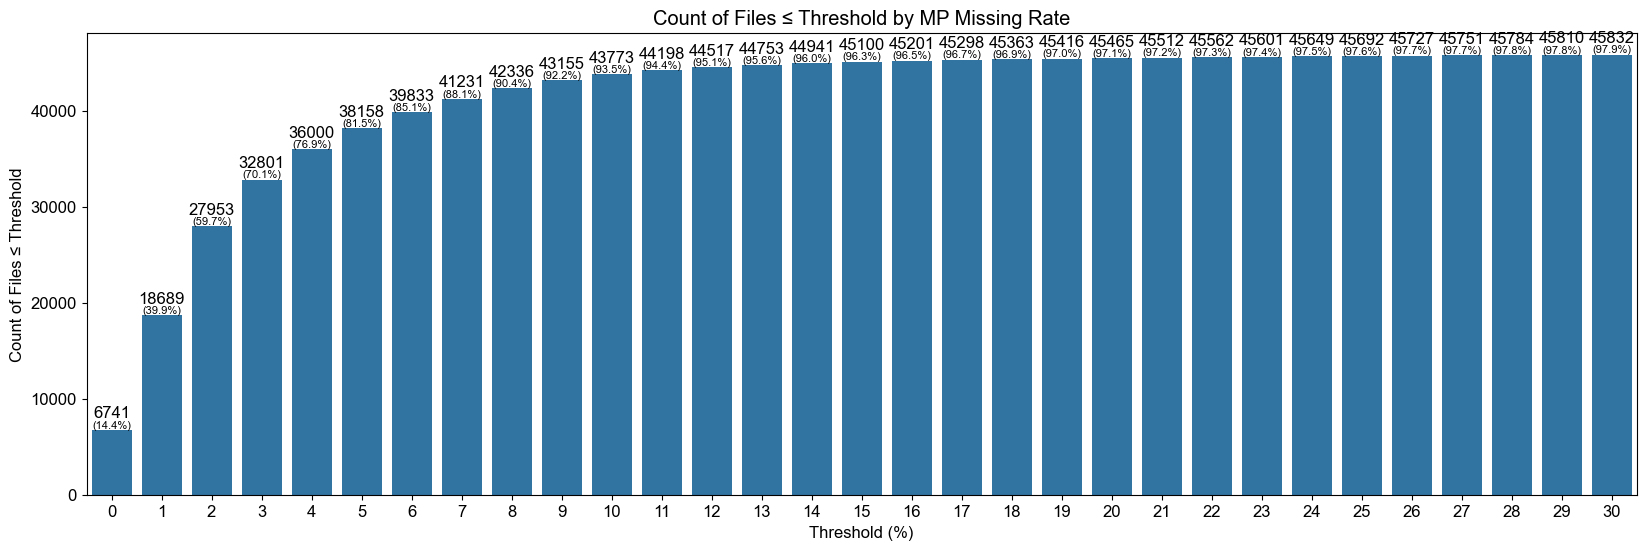

In [14]:
plot_missing_sum(missing_sum_df_30, len(df_missing_rate_combined))